In [1]:
import requests
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from fa2 import ForceAtlas2
import seaborn as sns
import numpy as np
from pprint import pprint
import pickle
import re
import string
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()

# Get Dataframe with espiodes

In [2]:
url = 'https://southpark.fandom.com/wiki/List_of_Episodes'
page = pd.read_html(url)

In [3]:
len(page)

34

In [4]:
def get_episodes_df(page):
    def clear_df(df):
        df_tmp = df.drop([0], axis=1)
        df_tmp.columns = df_tmp.loc[0].values
        df_tmp = df_tmp.drop([0])
        df_clean = df_tmp[(df_tmp['#'].str.isnumeric() == True) | (df_tmp['#'].isna() == True)].copy()
        df_clean['Title'] = df_clean['Title'].str.replace('\"', '')
        df_clean = df_clean[df_clean['Title'] != 'TBA']
        descriptions = [df_tmp.loc[i+1].values[0] for i in df_clean.index]
        df_clean['Descriptions'] = descriptions
        df_clean.reset_index(drop=True, inplace=True)
        return df_clean
    
    df_list = []

    for i, df_tmp in enumerate(page[4:28], start=1):
        df_tmp = clear_df(df_tmp)
        df_tmp['Season'] = i
        df_list.append(df_tmp)

    df_episodes = pd.concat(df_list, ignore_index=True)
    return df_episodes

In [5]:
df_episodes = get_episodes_df(page)

In [6]:
df_episodes.tail(20)

,Title,Air Date,Code,#,Descriptions,Season
289,The Problem with a Poo,"October 10, 2018",2203,290,Mr. Hankey’s offensive behavior puts him in je...,22
290,Tegridy Farms,"October 17, 2018",2204,291,Butters is selling vape pens and all kinds of ...,22
291,The Scoots,"October 31, 2018",2205,292,The kids plan to use the latest revolution in ...,22
292,Time To Get Cereal,"November 7, 2018",2206,293,When dead citizens start popping up all over t...,22
293,Nobody Got Cereal?,"November 14, 2018",2207,294,The boys break out of jail and are on the run ...,22
294,Buddha Box,"November 28, 2018",2208,295,Cartman just can’t deal with people any longer...,22
295,Unfulfilled,"December 5, 2018",2209,296,The citizens of South Park are enjoying all th...,22
296,Bike Parade,"December 12, 2018",2210,297,Despite the chaos at the Amazon Fulfillment Ce...,22
297,Mexican Joker,"September 25, 2019",2301,298,"In the pilot episode of the new hit series, Te...",23
298,Band in China,"October 2, 2019",2302,299,Randy lands himself in big trouble on a visit ...,23


# Get episodes scripts

In [9]:
def read_scripts(df_episodes):
    def clear_script(script):
        if script.shape[1] > 2:
            df_tmp = script[[0, 1]].copy()
        else:
            df_tmp = script.copy()
        df_tmp.drop([0,1], inplace=True)
        df_tmp.columns = ['Character', 'Lines']
        return df_tmp
    
    scripts = {}
    valid = {}
    for row in df_episodes.iterrows():
        title = row[1]['Title'].replace(' ', '_')
        title = title.replace('%', '%25')
        title = title.replace('!!!', '')
        title = title.replace('#', '')
        title = title.replace('\'', '%27')
        title = title.replace('?', '%3F')
        if title == 'Imaginationland_Episode_I':
            title = 'Imaginationland'
        elif title == 'Imaginationland_Episode_II':
            title == ' Imaginationland,_Episode_II'
        elif title == 'Crème_Fraiche':
            title == 'Crème_Fraiche'
        code = row[1]['Code']
        if code == '1414':
            continue
        # print(f'{code}: {title}')
        url_tmp = f'https://southpark.fandom.com/wiki/{title}/Script'
        script_raw = pd.read_html(url_tmp)
        scripts[code] = clear_script(script_raw[1])
        valid[code] = (len(script_raw), scripts[code].shape)
    return scripts, valid

In [10]:
scripts,valid = read_scripts(df_episodes)

In [13]:
# Manually downloaded script for episode 1414
df_1414 = pd.read_csv('1414.txt', sep='|', names=['Character', 'Lines'])
df_1414['Character'].replace('ScriptScene', np.NaN, inplace=True)
scripts['1414'] = df_1414

In [14]:
scripts['1414']

,Character,Lines
0,NaN,"The Marsh house, living room, night. Randy and..."
1,Reporter,Passenger said the Carnival cruise line smelle...
2,Sharon,"''[yawns]'' All right, it's late. I'm gonna ca..."
3,Randy,"Aw, you know, I can't really sleep. I'm just g..."
4,Sharon,"''[going up stairs, she stops and turns around..."
...,...,...
251,Sharon,"Shake Weight, you aren't really workout equipm..."
252,Shake Weight,Marriage is important. Keep your man happy. Wh...
253,Sharon,"I'll remember that now, thanks to you."
254,Shake Weight,It has been nice getting to know you. How abou...


In [15]:
with open('scripts.pickle', 'wb') as file:
    pickle.dump(scripts, file, protocol=pickle.HIGHEST_PROTOCOL)

# Text processing 

In [36]:
import nltk
from nltk import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [37]:
def delete_names(text, name_list):
    text_tmp = text
    for name in name_list:
        text_tmp = text_tmp.replace(' ' + name, '')
    return text_tmp

def clear_text(text, names, names_2_parts):
    text = re.sub("[\[].*?[\]]", "", text)
    text = delete_names(text, names_2_parts)
    return text

In [38]:
names = []
for code in df_episodes['Code'].values:
    names = names + list(scripts[code].Character.dropna().unique())
names = list(set(names))
names_2_parts = [name for name in names if len(name.split()) >= 2]
names = [name.lower() for name in names if name not in names_2_parts]

In [39]:
main_character = ['Cartman', 'Kenny', 'Kyle', 'Stan']

In [40]:
main_character_lines = []
for character in main_character:
    for episode in df_episodes.Code.values:
        text = ' '.join(scripts[episode][scripts[episode].Character == character].Lines.dropna().values)
        data = {'Character' : character,
               'Episode': episode,
               'Clean_text': [clear_text(text, names, names_2_parts)]}
        main_character_lines.append(pd.DataFrame(data=data))
df_char_lines = pd.concat(main_character_lines, ignore_index=True)

In [41]:
df_char_lines

,Character,Episode,Clean_text
0,Cartman,101,I know what it means! I'm not telling you. He-...
1,Cartman,102,"Ugh, I hate those things. Well, you know, you'..."
2,Cartman,103,"Okay, Mom. Dude, that's sick mom. Drive, Drive..."
3,Cartman,104,"Eh. You're making me sick, dude. No way. Every..."
4,Cartman,105,"Hey Stan, where'd you get that black eye? Your..."
...,...,...,...
1231,Stan,2308,"Dude, Kyle, why are you talking about all this..."
1232,Stan,2309,About what? PC Babies? What the hell is this? ...
1233,Stan,2310,
1234,Stan,2401,"I'm, I'm here. It's not school! It's a freakin..."


# Sentiment analysis 

In [42]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mailt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [43]:
''.join(df_char_lines.Clean_text.loc[0])

"I know what it means! I'm not telling you. He-yeah, that's what Kyle's little brother is all right!  Ow!  That's 'cause I was having these... bogus nightmares. Well, I dreamt that I was lying in my bed... ...in the dark, when all of a sudden this bright blue light filled the room. Then slowly my bedroom door began to open...  ...and then the next thing I remember, I was being drug through a hallway. Weeaak! Then I was lying on a table... ...and these scary aliens wanted to operate on me. And they had big heads and big black eyes. What? No, it was just a dream, my mom said so. Oh, shut up guys! You're just trying to make me scared. And it's not working. Kick ass.  Huh? Eh, no, that, that was just a dream. And I'm not fat, I'm big boned! Oh! Oh! No! Uh-I mean, eh, why would they do that? No! Shut up, dildo! Oh! God damn it, they didn't do anything to my ass! It was just a dream! Shut up! Shut up you guys, it's not working. Heh, somebody's baking brownies.  Heh, heh, that's a, that's, th

In [44]:
sid=SentimentIntensityAnalyzer()

In [45]:
sid.polarity_scores(''.join(df_char_lines.Clean_text.loc[0]))

{'neg': 0.16, 'neu': 0.721, 'pos': 0.119, 'compound': -0.9903}

In [46]:
df_char_lines['Sentiment_Scores'] = df_char_lines['Clean_text'].apply(lambda x: sid.polarity_scores(''.join(x)))

In [47]:
df_char_lines = pd.concat([df_char_lines, df_char_lines['Sentiment_Scores'].apply(pd.Series)], axis=1)

In [48]:
df_char_lines

,Character,Episode,Clean_text,Sentiment_Scores,neg,neu,pos,compound
0,Cartman,101,I know what it means! I'm not telling you. He-...,"{'neg': 0.16, 'neu': 0.721, 'pos': 0.119, 'com...",0.160,0.721,0.119,-0.9903
1,Cartman,102,"Ugh, I hate those things. Well, you know, you'...","{'neg': 0.104, 'neu': 0.711, 'pos': 0.185, 'co...",0.104,0.711,0.185,0.9897
2,Cartman,103,"Okay, Mom. Dude, that's sick mom. Drive, Drive...","{'neg': 0.144, 'neu': 0.721, 'pos': 0.135, 'co...",0.144,0.721,0.135,-0.9195
3,Cartman,104,"Eh. You're making me sick, dude. No way. Every...","{'neg': 0.199, 'neu': 0.722, 'pos': 0.079, 'co...",0.199,0.722,0.079,-0.9888
4,Cartman,105,"Hey Stan, where'd you get that black eye? Your...","{'neg': 0.161, 'neu': 0.727, 'pos': 0.112, 'co...",0.161,0.727,0.112,-0.9840
...,...,...,...,...,...,...,...,...
1231,Stan,2308,"Dude, Kyle, why are you talking about all this...","{'neg': 0.042, 'neu': 0.855, 'pos': 0.104, 'co...",0.042,0.855,0.104,0.7236
1232,Stan,2309,About what? PC Babies? What the hell is this? ...,"{'neg': 0.15, 'neu': 0.754, 'pos': 0.096, 'com...",0.150,0.754,0.096,-0.5502
1233,Stan,2310,,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
1234,Stan,2401,"I'm, I'm here. It's not school! It's a freakin...","{'neg': 0.069, 'neu': 0.835, 'pos': 0.096, 'co...",0.069,0.835,0.096,0.9373


In [49]:
df_char_lines.groupby(['Character']).agg({'compound':['mean'], 'neg':['mean'], 'neu':['mean'], 'pos':['mean']})

,compound,neg,neu,pos
,mean,mean,mean,mean
Character,,,,
Cartman,0.144104,0.113495,0.710084,0.131078
Kenny,-0.059695,0.044417,0.506728,0.028149
Kyle,-0.073936,0.115799,0.713188,0.116019
Stan,0.095031,0.103586,0.712942,0.125249


In [50]:
df_char_lines['Episode_Numeric'] = df_char_lines['Episode'].astype('int64')

In [51]:
df_char_lines[df_char_lines.Character == 'Kenny'].compound.values

array([ 0.5175,  0.    , -0.7209,  0.2732,  0.4051, -0.8141,  0.    ,
        0.    ,  0.    ,  0.    ,  0.2727,  0.4453, -0.5296,  0.    ,
       -0.6734,  0.    ,  0.    ,  0.    , -0.926 , -0.7922,  0.    ,
       -0.6822, -0.4344, -0.5106, -0.9363, -0.7276,  0.    ,  0.    ,
        0.    ,  0.2444, -0.7696,  0.5312,  0.2244, -0.2905,  0.    ,
       -0.7962,  0.    ,  0.    ,  0.    , -0.8372,  0.6433,  0.    ,
       -0.4753,  0.2481,  0.    ,  0.    ,  0.7627, -0.6458, -0.8597,
       -0.7669,  0.5574,  0.8752,  0.7585, -0.9398, -0.6645,  0.    ,
        0.    ,  0.6606,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.5053,
        0.3111,  0.    ,  0.5951, -0.6093,  0.    ,  0.    ,  0.    ,
        0.9254,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
       -0.866 ,  0. 

<BarContainer object of 309 artists>

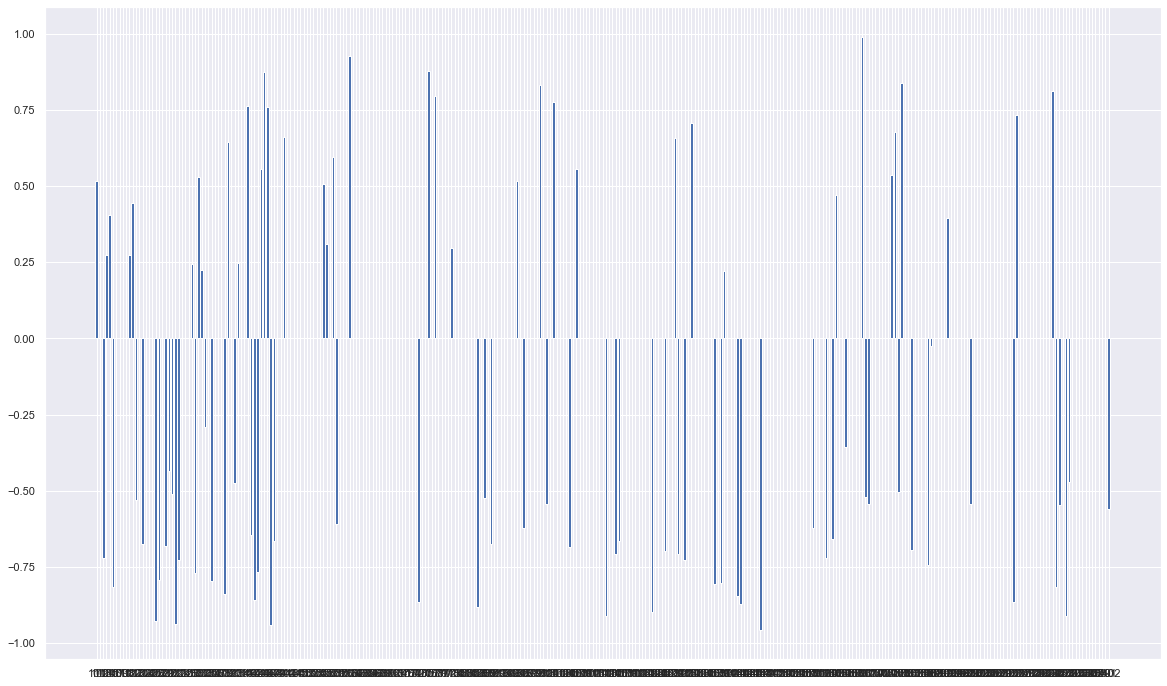

In [52]:
plt.figure(figsize=(20,12))
plt.bar(df_char_lines[df_char_lines.Character == 'Kenny'].Episode, df_char_lines[df_char_lines.Character == 'Kenny'].compound)

I need a column with the seasons so we can group by season. A plot for every episode is too chaotic.

In [53]:
def getSeason(x):
    return df_episodes[df_episodes.Code == x].Season.values[0]


df_char_lines['Season'] = df_char_lines.Episode.apply(lambda x : getSeason(x))

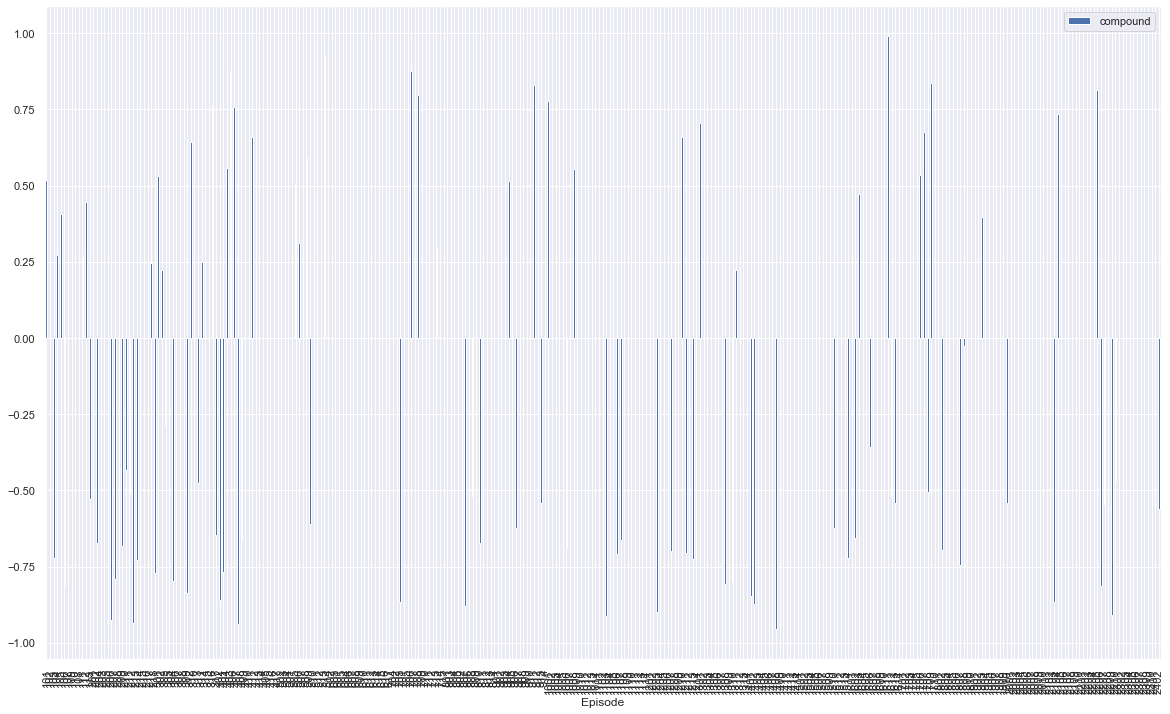

In [54]:
df_char_lines[df_char_lines.Character == 'Kenny'].plot(kind='bar',x='Episode', y='compound',figsize=(20,12))

In [55]:
df_char_lines.head()

,Character,Episode,Clean_text,Sentiment_Scores,neg,neu,pos,compound,Episode_Numeric,Season
0,Cartman,101,I know what it means! I'm not telling you. He-...,"{'neg': 0.16, 'neu': 0.721, 'pos': 0.119, 'com...",0.160,0.721,0.119,-0.9903,101,1
1,Cartman,102,"Ugh, I hate those things. Well, you know, you'...","{'neg': 0.104, 'neu': 0.711, 'pos': 0.185, 'co...",0.104,0.711,0.185,0.9897,102,1
2,Cartman,103,"Okay, Mom. Dude, that's sick mom. Drive, Drive...","{'neg': 0.144, 'neu': 0.721, 'pos': 0.135, 'co...",0.144,0.721,0.135,-0.9195,103,1
3,Cartman,104,"Eh. You're making me sick, dude. No way. Every...","{'neg': 0.199, 'neu': 0.722, 'pos': 0.079, 'co...",0.199,0.722,0.079,-0.9888,104,1
4,Cartman,105,"Hey Stan, where'd you get that black eye? Your...","{'neg': 0.161, 'neu': 0.727, 'pos': 0.112, 'co...",0.161,0.727,0.112,-0.9840,105,1


In [56]:
df_char_lines.to_csv('Character_lines_episodes.csv', index=False)

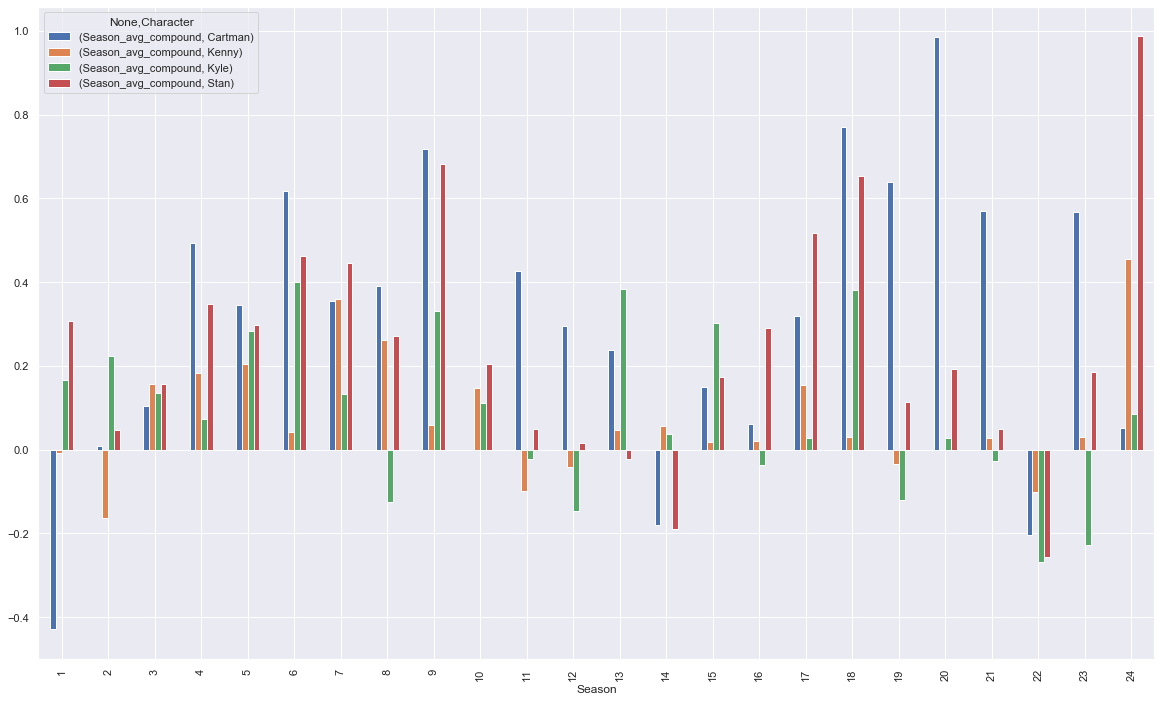

In [108]:
test = df_char_lines.groupby(['Season', 'Character']).agg(Season_avg_compound=('compound', 'mean')).unstack('Character')\
        .plot(kind='bar',figsize=(20,12))

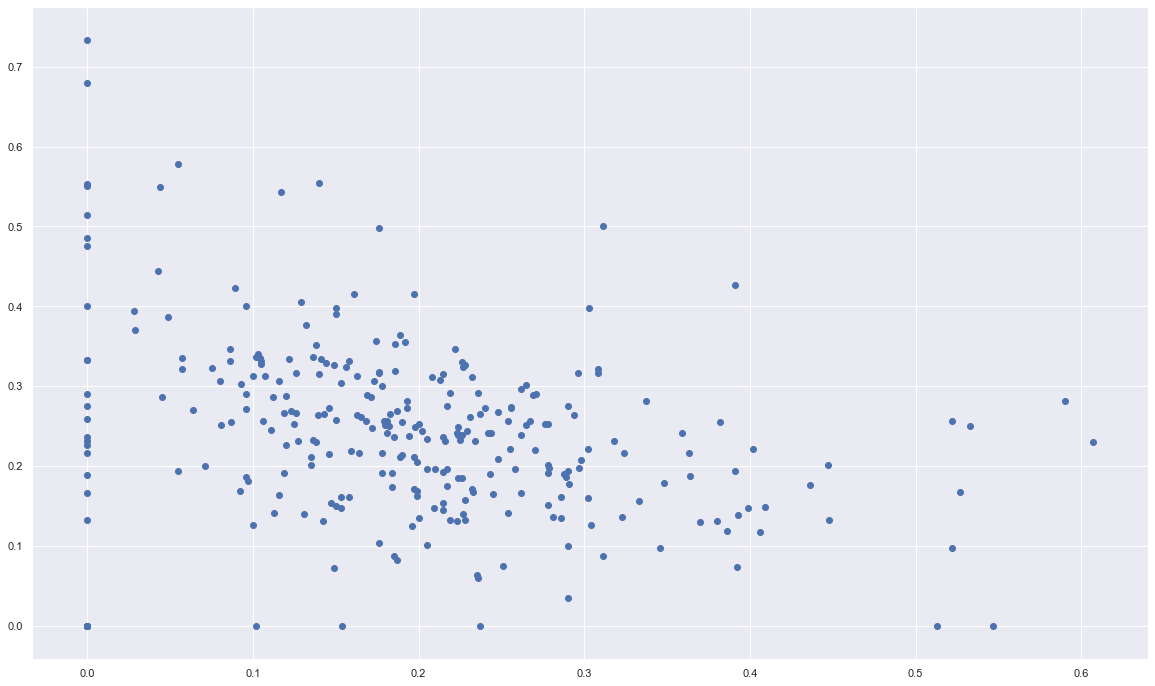

In [39]:
plt.figure(figsize=(20,12))
plt.scatter(df_char_lines[df_char_lines.Character == 'Kyle'].neg, df_char_lines[df_char_lines.Character == 'Kyle'].pos)

In [40]:
df_char_lines[df_char_lines.Character == 'Cartman'].Episode_Numeric

0       101
1       102
2       103
3       104
4       105
       ... 
304    2308
305    2309
306    2310
307    2401
308    2402
Name: Episode_Numeric, Length: 309, dtype: int64

In [41]:
df_char_lines[df_char_lines.Character == 'Kenny']

,Character,Episode,Clean_text,Sentiment_Scores,neg,neu,pos,compound,Episode_Numeric
309,Kenny,101,"[oh, nooo, look, foot, touch, worry, alright, ...","{'neg': 0.31, 'neu': 0.552, 'pos': 0.138, 'com...",0.310,0.552,0.138,-0.3595,101
310,Kenny,102,"[big, biggest, breast, seen, oh]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,102
311,Kenny,103,"[maybe, suck, hey, little, like, vagina, thank...","{'neg': 0.265, 'neu': 0.36, 'pos': 0.374, 'com...",0.265,0.360,0.374,0.4641,103
312,Kenny,104,"[oh, think, screwing, check, think, said, gay,...","{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",0.444,0.556,0.000,-0.5859,104
313,Kenny,105,"[hey, guy, talked, told, almost, mmmmmm, gonna...","{'neg': 0.0, 'neu': 0.824, 'pos': 0.176, 'comp...",0.000,0.824,0.176,0.4939,105
...,...,...,...,...,...,...,...,...,...
613,Kenny,2308,"[yeah, anything, morrow, got, flushing]","{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.000,0.645,0.355,0.2960,2308
614,Kenny,2309,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000,2309
615,Kenny,2310,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000,2310
616,Kenny,2401,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000,2401


# Sandbox

In [326]:
url_tmp = 'https://southpark.fandom.com/wiki/The_Scoots/Script'
script_raw = pd.read_html(url_tmp)

In [329]:
script_raw[1]

,0,1
0,The Scoots,The Scoots
1,NaN,NaN
2,NaN,An October afternoon in South Park. An adult n...
3,Adult Kenny,October was always my favorite month. [Stan an...
4,Mr. Mackey,Whoa! [trips over something and falls down] Wh...
...,...,...
228,Adult Kenny,Mr. Mackey was able to get back to the town an...
229,The boys,[approach a house and ring the doorbell] Trick...
230,Kenny,[brightly] (Trick or treat!)
231,Adult Kenny,It was the last Halloween that still felt like...


In [123]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentence = "fucking jew"
vs = analyzer.polarity_scores(sentence)

In [124]:
vs

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}